# script COTO

In [28]:
import pandas as pd
import random
import requests
import json
import seaborn as sns
from bs4 import BeautifulSoup
from datetime import datetime, timedelta

In [35]:
articulos = {'coto':
                {'salamin': 'https://www.cotodigital3.com.ar/sitios/cdigi/producto/-salamin-tandfin-cagnoli-xkg/_/A-00080962-00080962-200', 
                'cerveza': 'https://www.cotodigital3.com.ar/sitios/cdigi/producto/-cerveza-fresquita-andes-origen-473-ml/_/A-00545197-00545197-200', 
                'papa_fritas': 'https://www.cotodigital3.com.ar/sitios/cdigi/producto/-papas-fritas-clasicas-lays-40g/_/A-00567578-00567578-200',
                 'queso_azul': 'https://www.cotodigital3.com.ar/sitios/cdigi/producto/-queso-azul--santa-rosa-xkg/_/A-00000156-00000156-200'
                },
            'jumbo':
                {'cerveza': 'https://www.jumbo.com.ar/cerveza-andes-origen-roja-botella-retornable-1ltx1/p',
                 'queso_azul': 'https://www.jumbo.com.ar/queso-azul-santa-rosa-2-2/p'
                
                },                  
            'carrefour': 
                {'cerveza': 'https://www.carrefour.com.ar/cerveza-rubia-andes-origen-473-cc/p',
                'queso_azul':'https://www.carrefour.com.ar/queso-azul-santa-rosa-x-kg-683923/p'}
           }

In [36]:
def get_coto(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36'
    }
    
    try:
        response = requests.get(url, headers=headers)        
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            
            product_name = soup.find('h1', class_='product_page').get_text(strip=True)
            product_price = soup.find('span', class_='atg_store_newPrice').get_text(strip=True).replace('$', '').replace('.', '').replace(',', '.')
            
            print(f'Product Name: {product_name}')
            print(f'Price: {product_price}')
            return product_price
        
        else:
            print(f'Failed to retrieve webpage, status code: {response.status_code}')
            return None
    
    except requests.RequestException as e:
        print(f'Request failed: {e}')
        return None
    
    
def get_jumbo(url):    
    
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36'}
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        script = soup.find('script', {'type': 'application/ld+json'})
        
        if script:
            data = json.loads(script.string)
            product_name = data.get('name')
            product_price = data.get('offers', {}).get('lowPrice')

            print(f'Product Name: {product_name}')
            print(f'Price: {product_price}')
            return product_price
        
        else:
            print('Product data in JSON format not found.')
    else:
        print(f'Failed to retrieve webpage, status code: {response.status_code}')
        
        
def create_df(articulos, product_key):
    data_dict = {}
    
    store_function_mapping = {
        'coto': get_coto,
        'jumbo': get_jumbo,
        'carrefour': get_jumbo
    }
    
    for store, products in articulos.items():
        if product_key in products:
            
            if store in store_function_mapping:  
                get_function = store_function_mapping[store]
                product_price = get_function(products[product_key])
                data_dict[store] = float(product_price)
                
    df = pd.DataFrame([data_dict])   
    current_date = datetime.now().strftime('%d-%m-%Y')
    df.index = [current_date]    
    
    return df

def mock_data_random_decrease(df, days_back, percentage_decrease_min, percentage_decrease_max):
    new_df = df.copy()
    
    new_df.index = pd.to_datetime(new_df.index, format='%d-%m-%Y')    
    last_known_prices = new_df.iloc[-1]

    for day in range(1, days_back + 1):
        random_decrease = random.uniform(percentage_decrease_min, percentage_decrease_max) / 100        
        past_date = new_df.index[-1] - timedelta(days=1)
        decreased_prices = last_known_prices * (1 - random_decrease)
        new_df.loc[past_date] = decreased_prices
        last_known_prices = decreased_prices
    new_df.sort_index(ascending=True, inplace=True)    
   
    return new_df

In [39]:
item = 'queso_azul'

In [37]:
df_cerveza = create_df(articulos, item)
df_cerveza

Product Name: Queso Azul. . SANTA ROSA Xkg
Price: 15855.00
Product Name: Queso Azul Santa Rosa Horma 1 Kg
Price: 15999
Product Name: Queso azul Santa Rosa x kg.
Price: 16785


,coto,jumbo,carrefour
16-04-2024,15855.0,15999.0,16785.0


In [41]:
new_df_cerveza = mock_data_random_decrease(df_cerveza, 
                                           days_back=30, 
                                           percentage_decrease_min=0.1,
                                           percentage_decrease_max=0.15)

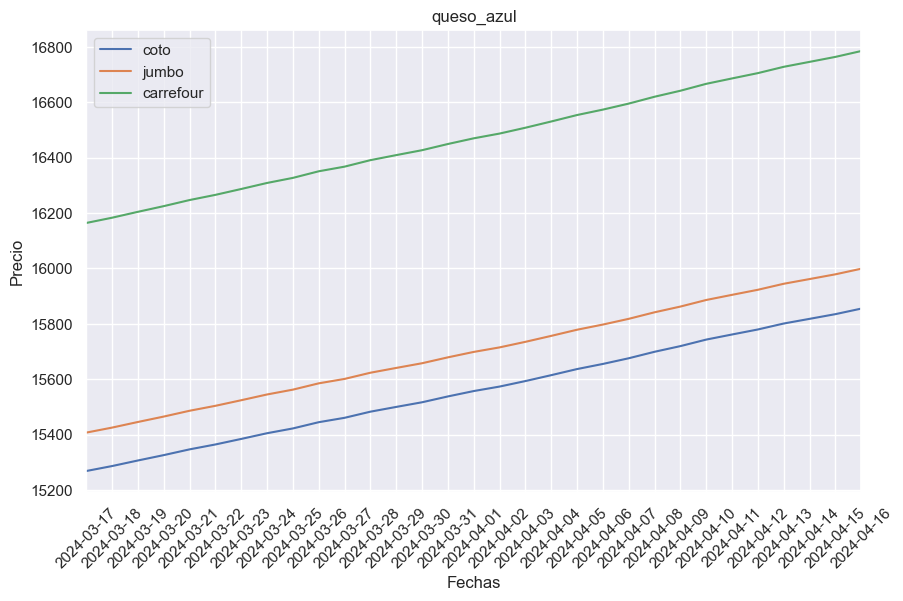

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sns.set_theme()
ax = new_df_cerveza.plot(kind='line', figsize=(10, 6))

ax.set_xlabel('Fechas')
ax.set_ylabel('Precio')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
ax.set_title(item)
plt.show()


In [27]:
import requests

def get_meli(item_id, access_token=None):
    url = f'https://api.mercadolibre.com/items/{item_id}/sale_price'
    headers = {
     #   'Authorization': f'Bearer {access_token}'
    }
    
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        data = response.json()
        return data.get('amount')
    else:
        raise Exception(f"Error fetching item price: {response.status_code} {response.text}")

item_price = get_meli('MLA816019440')


Exception: Error fetching item price: 401 {"error":"Missing access token","status":401,"code":"UNAUTHORIZED"}